## Max Wienandts

Problem Statement:
-  Is BERT and DistilBERT appropriate to sentiment analysis? Is Latent Dirichlet Allocation (LDA) appropriate for topic modeling?

|SUMMARY|
|:------------------------------------------------|
|[**1. Baseline model LSTM**](#Baseline_model_LSTM)|
|[**2. BERT**](#BERT)|
|[**3. DistilBERT**](#DistilBERT)|

This project have 4 Jupyter notebook:
- 1 ETL and EDA.ipynb;
- 2 LSTM BERT DistilBERT.ipynb;
- 3 Topic modeling.ipynb; and
- 4 Production.ipynb.

They should be runned in order. \
The objective of the first notebook is to known better our dataset and to clean it. \
The second notebook have the models related to sentiment analysis. \
The third one have the topic modeling. \
Finally, the last notebook is an example to how to apply the sentiment and topic models to an dataset and to a custow review.

In [14]:
import time
import json

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, LSTM

import transformers
from transformers import BertTokenizer
from transformers import TFBertModel 
from transformers import DistilBertTokenizer
from transformers import TFDistilBertModel

In [9]:
# Notebook variables
path_read_dataset = 'df_sentiment_analysis_topic_modeling.csv'

# Operational system. If Linux "1", otherwise "0".
OS_system = 1

# Path to save word to index file used in the baseline LSTM model
checkpoint_word2idx_base_LSTM_path_win = r"C:\Users\maxwi\Python\Harvard\Electives\1 CSCI S-89 Introduction to Deep Learning\Project\1 sentiment analysis\Glassdoor 2\models\base_LSTM\word2idx.txt"
checkpoint_word2idx_base_LSTM_path_linux = "/home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/base_LSTM/model_base_LSTM"

# Path to save baseline LSTM model
checkpoint_base_LSTM_path_win_aux = r"C:\Users\maxwi\Python\Harvard\Electives\1 CSCI S-89 Introduction to Deep Learning\Project\1 sentiment analysis\Glassdoor 2\models\base_LSTM\model_base_LSTM"
checkpoint_base_LSTM_path_win = checkpoint_base_LSTM_path_win_aux + "_{epoch:04d}.h5"
checkpoint_base_LSTM_path_linux_aux = "/home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/base_LSTM/model_base_LSTM"
checkpoint_base_LSTM_path_linux = checkpoint_base_LSTM_path_linux_aux + "_{epoch:04d}.h5"

# Path to save BERT model
checkpoint_BERT_path_win_aux = r'C:\Users\maxwi\Python\Harvard\Electives\1 CSCI S-89 Introduction to Deep Learning\Project\1 sentiment analysis\Glassdoor 2\models\BERT\model_BERT'
checkpoint_BERT_path_win = checkpoint_BERT_path_win_aux + "_{epoch:04d}.h5"
checkpoint_BERT_path_linux_aux = '/home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/BERT/model_BERT'
checkpoint_BERT_path_linux = checkpoint_BERT_path_linux_aux + "_{epoch:04d}.h5"

# Path to save DistilBERT model
checkpoint_DistilBERT_path_win_aux = r'C:\Users\maxwi\Python\Harvard\Electives\1 CSCI S-89 Introduction to Deep Learning\Project\1 sentiment analysis\Glassdoor 2\models\DistilBERT\model_DistilBERTBERT'
checkpoint_DistilBERT_path_win = checkpoint_DistilBERT_path_win_aux + "_{epoch:04d}.h5"
checkpoint_DistilBERT_path_linux_aux = '/home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/DistilBERT/model_DistilBERTBERT'
checkpoint_DistilBERT_path_linux = checkpoint_DistilBERT_path_linux_aux + "_{epoch:04d}.h5"

if OS_system == 1:
    checkpoint_word2idx_base_LSTM_path = checkpoint_word2idx_base_LSTM_path_linux
    checkpoint_base_LSTM_path = checkpoint_base_LSTM_path_linux
    checkpoint_BERT_path = checkpoint_BERT_path_linux
    checkpoint_DistilBERT_path = checkpoint_DistilBERT_path_linux
else:
    checkpoint_word2idx_base_LSTM_path = checkpoint_word2idx_base_LSTM_path_win
    checkpoint_base_LSTM_path = checkpoint_base_LSTM_path_win
    checkpoint_BERT_path = checkpoint_BERT_path_win
    checkpoint_DistilBERT_path = checkpoint_DistilBERT_path_win

In [3]:
# Read only the necessary columns to sentiment analysis.
df = pd.read_csv(path_read_dataset, usecols = ['review', 'target'])
# df = df.iloc[0:10000] # Used to test the algorithm
df.head()

,review,target
0,I can not think of any,0
1,little advancement based on owners pretty cheap,0
2,Low career advancement opportunity and politics,0
3,The peolpe. Everone that I worked with was fr...,1
4,Dealing with angry customers and putting up wi...,0


In [4]:
# Separate train, validation and test
df_train_2, df_test = train_test_split(df, test_size = 0.20, random_state = 1)
df_train, df_val = train_test_split(df_train_2, test_size = 0.20, random_state = 1)

X_train = df_train['review']
X_val = df_val['review']
X_test = df_test['review']

y_train = df_train['target']
y_val = df_val['target']
y_test = df_test['target']

print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_val)}')
print(f'Test size: {len(X_test)}')

Train size: 1073263
Validation size: 268316
Test size: 335395


In [5]:
# Define functions to analyze the performance 
# Plot the train and test errors versus iteration step
def plot_train_val_metric(model_history, metric, ylabel, savefig_path):
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes.plot(range(1, len(model_history.history[metric]) + 1), model_history.history[metric], label = 'Training')
    axes.plot(range(1, len(model_history.history[metric]) + 1), model_history.history['val_' + metric], label = 'Validation')
    best_metric = np.nanmax(model_history.history['val_' + metric])
    epoch_best_metric = np.nanargmax(model_history.history['val_' + metric]) + 1
    axes.axvline(epoch_best_metric,
                    c='k', ls='--',
                    label=f'best val {metric} = {best_metric:.6f}, epoch = {epoch_best_metric}')


    axes.set_xlabel('Epoch')
    axes.set_ylabel(ylabel)
    axes.set_title(f"Training and Validation {metric}")
    axes.legend()
   
    plt.show()
    fig.savefig(savefig_path, dpi = fig.dpi)
    plt.close();
   
    return epoch_best_metric, best_metric
    
# Performance evaluation
def plot_confusion_matrix(y_true, y_pred, title, savefig_path):

    # Matriz de confusão
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negatives','False Positives','False Negatives', 'True Positives']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_percentages, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    fig = plt.figure(figsize=(8,5))
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_xlabel('Y predicted')
    ax.set_ylabel('Y true')
    ax.set_title(title, fontsize = 10)
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()
    fig.savefig(savefig_path, dpi = fig.dpi)
    plt.close()

# Save all performance metrics in one table.
def save_metrics(model_name, model, X_train, y_train, X_val, y_val, X_test, y_test
                 , preprocess_time, model_time
                 , metrics_dict_train, metrics_dict_val, metrics_dict_test, savedf_path):
    # Predict in train and test
    if model_name == 'Baseline LSTM':
        y_pred_proba_train = model.predict(X_train)
        y_pred_train = [1 if x > 0.5 else 0 for x in y_pred_proba_train]

        start_val_time = time.time()
        y_pred_proba_val = model.predict(X_val)
        y_pred_val = [1 if x > 0.5 else 0 for x in y_pred_proba_val]
        end_val_time = time.time()
        predict_val_time = (end_val_time - start_val_time)
        predict_val_time = f'{predict_val_time/60:.2f}'
        
        start_test_time = time.time()
        y_pred_proba_test = model.predict(X_test)
        y_pred_test = [1 if x > 0.5 else 0 for x in y_pred_proba_test]
        end_test_time = time.time()
        predict_test_time = (end_test_time - start_test_time)
        predict_test_time = f'{predict_test_time/60:.2f}'
    elif model_name == 'BERT':
        y_pred_proba_train = model.predict(x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']})
        y_pred_train = [1 if x > 0.5 else 0 for x in y_pred_proba_train]

        start_val_time = time.time()
        y_pred_proba_val = model.predict(x = {'input_ids':X_val['input_ids'], 'attention_mask':X_val['attention_mask']})
        y_pred_val = [1 if x > 0.5 else 0 for x in y_pred_proba_val]
        end_val_time = time.time()
        predict_val_time = (end_val_time - start_val_time)
        predict_val_time = f'{predict_val_time/60:.2f}'

        start_test_time = time.time()
        y_pred_proba_test = model.predict(x = {'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']})
        y_pred_test = [1 if x > 0.5 else 0 for x in y_pred_proba_test]
        end_test_time = time.time()
        predict_test_time = (end_test_time - start_test_time)
        predict_test_time = f'{predict_test_time/60:.2f}'
    elif model_name == 'DistilBERT':
        y_pred_proba_train = model.predict(x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']})
        y_pred_train = [1 if x > 0.5 else 0 for x in y_pred_proba_train]

        start_val_time = time.time()
        y_pred_proba_val = model.predict(x = {'input_ids':X_val['input_ids'], 'attention_mask':X_val['attention_mask']})
        y_pred_val = [1 if x > 0.5 else 0 for x in y_pred_proba_val]
        end_val_time = time.time()
        predict_val_time = (end_val_time - start_val_time)
        predict_val_time = f'{predict_val_time/60:.2f}'
        
        start_test_time = time.time()
        y_pred_proba_test = model.predict(x = {'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']})
        y_pred_test = [1 if x > 0.5 else 0 for x in y_pred_proba_test]
        end_test_time = time.time()
        predict_test_time = (end_val_time - start_test_time)
        predict_test_time = f'{predict_test_time/60:.2f}'

    y_pred = {}
    y_pred['train_proba'] = y_pred_proba_train
    y_pred['train'] = y_pred_train
    y_pred['val_proba'] = y_pred_proba_val
    y_pred['val'] = y_pred_val
    y_pred['test_proba'] = y_pred_proba_test
    y_pred['test'] = y_pred_test
    
    # Save metrics in dict
    # Train
    accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
    metrics_dict_train['name'].append(model_name)
    metrics_dict_train['accuracy'].append(accuracy_train)
    metrics_dict_train['precision'].append(round(precision_score(y_train, y_pred_train), 4))
    metrics_dict_train['recall/sensitivity'].append(round(recall_score(y_train, y_pred_train), 4))
    metrics_dict_train['specificity'].append(round(recall_score(y_train, y_pred_train, pos_label = 0), 4))
    metrics_dict_train['F1'].append(round(f1_score(y_train, y_pred_train), 4))
    metrics_dict_train['ROC AUC'].append(round(roc_auc_score(y_train, y_pred_proba_train), 4))
    metrics_dict_train['preprocess time'].append(preprocess_time)
    metrics_dict_train['training time'].append(model_time)

    # Validation
    accuracy_val = round(accuracy_score(y_val, y_pred_val), 4)
    metrics_dict_val['name'].append(model_name)
    metrics_dict_val['accuracy'].append(accuracy_val)
    metrics_dict_val['precision'].append(round(precision_score(y_val, y_pred_val), 4))
    metrics_dict_val['recall/sensitivity'].append(round(recall_score(y_val, y_pred_val), 4))
    metrics_dict_val['specificity'].append(round(recall_score(y_val, y_pred_val, pos_label = 0), 4))
    metrics_dict_val['F1'].append(round(f1_score(y_val, y_pred_val), 4))
    metrics_dict_val['ROC AUC'].append(round(roc_auc_score(y_val, y_pred_proba_val), 4))
    metrics_dict_val['predict time'].append(predict_val_time)
    
    # Test
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
    metrics_dict_test['name'].append(model_name)
    metrics_dict_test['accuracy'].append(accuracy_test)
    metrics_dict_test['precision'].append(round(precision_score(y_test, y_pred_test), 4))
    metrics_dict_test['recall/sensitivity'].append(round(recall_score(y_test, y_pred_test), 4))
    metrics_dict_test['specificity'].append(round(recall_score(y_test, y_pred_test, pos_label = 0), 4))
    metrics_dict_test['F1'].append(round(f1_score(y_test, y_pred_test), 4))
    metrics_dict_test['ROC AUC'].append(round(roc_auc_score(y_test, y_pred_proba_test), 4))
    metrics_dict_test['predict time'].append(predict_test_time)
    
    # Print accuracy
    print("Model:", model_name)
    print(f"\tTrain Accuracy: {accuracy_train:.4f}")
    print(f"\tValidation Accuracy: {accuracy_val:.4f}")
    print(f"\tTest Accuracy: {accuracy_test:.4f}")

    pd.DataFrame(metrics_dict_train).to_csv(savedf_path + "_metrics_dict_train.csv", index = False)
    pd.DataFrame(metrics_dict_val).to_csv(savedf_path + "metrics_dict_val.csv", index = False)
    pd.DataFrame(metrics_dict_test).to_csv(savedf_path + "metrics_dict_test.csv", index = False)

    return metrics_dict_train, metrics_dict_val, metrics_dict_test, y_pred

metrics_train = {}
metrics_train['name'] = []
metrics_train['accuracy'] = []
metrics_train['precision'] = []
metrics_train['recall/sensitivity'] = []
metrics_train['specificity'] = []
metrics_train['F1'] = []
metrics_train['ROC AUC'] = []
metrics_train['preprocess time'] = []
metrics_train['training time'] = []

metrics_val = {}
metrics_val['name'] = []
metrics_val['accuracy'] = []
metrics_val['precision'] = []
metrics_val['recall/sensitivity'] = []
metrics_val['specificity'] = []
metrics_val['F1'] = []
metrics_val['ROC AUC'] = []
metrics_val['predict time'] = []

metrics_test = {}
metrics_test['name'] = []
metrics_test['accuracy'] = []
metrics_test['precision'] = []
metrics_test['recall/sensitivity'] = []
metrics_test['specificity'] = []
metrics_test['F1'] = []
metrics_test['ROC AUC'] = []
metrics_test['predict time'] = []

<div id='Baseline_model_LSTM' />

## Baseline model LSTM

In [11]:
# Word Encoding
start = time.time()
# For the LSTM model, remove punctuations.
X_train_LSTM = X_train.replace({r'[^\w\s]': ' '}, regex = True)
X_val_LSTM = X_val.replace({r'[^\w\s]': ' '}, regex = True)
X_test_LSTM = X_test.replace({r'[^\w\s]': ' '}, regex = True)

# Make list of unique words
vec_word = []
for review in X_train_LSTM:
    for word in review.split():
        vec_word.append(word)
vec_word = list(set(vec_word))
vec_word.sort()

# word<>index mappings
word2idx = {wo : i + 2 for i, wo in enumerate(vec_word)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1   # For unknown words
idx2word = {i + 2 : wo for i,wo in enumerate(vec_word)}
vocabulary_size = len(word2idx)
print(f'Vocabulary size: {vocabulary_size}')
# Save word2idx
with open(checkpoint_word2idx_base_LSTM_path, 'w') as convert_file:
     convert_file.write(json.dumps(word2idx))
    
# Encode the sentences
def encode_row(review, word2idx):
    ecoded_row = []
    for word in review.split():
        if word in word2idx:
            ecoded_row.append(word2idx[word])
        else:
            ecoded_row.append(word2idx["<UNK>"])
    return ecoded_row

X_train_LSTM_encoded = []
for review in X_train_LSTM:
    econded_review = encode_row(review, word2idx)
    X_train_LSTM_encoded.append(econded_review)
    
X_val_LSTM_encoded = []
for review in X_val_LSTM:
    econded_review = encode_row(review, word2idx)
    X_val_LSTM_encoded.append(econded_review)
    
X_test_LSTM_encoded = []
for review in X_test_LSTM:
    econded_review = encode_row(review, word2idx)
    X_test_LSTM_encoded.append(econded_review)

# PAD reviews
max_len = 60 # Using a max length of 60, we get more than 95% of the reviews.
X_train_LSTM_encoded = pad_sequences(X_train_LSTM_encoded, maxlen = max_len, padding = 'pre')
X_val_LSTM_encoded = pad_sequences(X_val_LSTM_encoded, maxlen = max_len, padding = 'pre')
X_test_LSTM_encoded = pad_sequences(X_test_LSTM_encoded, maxlen = max_len, padding = 'pre')

# Tensor object
tf_train_LSTM = tf.data.Dataset.from_tensor_slices((X_train_LSTM_encoded, y_train))
tf_train_LSTM = tf_train_LSTM.shuffle(buffer_size = 32, seed = 1).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE )

tf_val_LSTM = tf.data.Dataset.from_tensor_slices((X_val_LSTM_encoded, y_val))
tf_val_LSTM = tf_val_LSTM.shuffle(buffer_size = 32, seed = 1).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE )

tf_test_LSTM = tf.data.Dataset.from_tensor_slices((X_test_LSTM_encoded, y_test))
tf_test_LSTM = tf_test_LSTM.shuffle(buffer_size = 32, seed = 1).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE )

end = time.time()
base_LSTM_preprocess_time = (end - start)
base_LSTM_preprocess_time = f'{base_LSTM_preprocess_time/60:.2f}'
print('Run time in minutes:', base_LSTM_preprocess_time)

Vocabulary size: 101615
Run time in minutes: 0.51


In [7]:
# Base model LSTM
def create_base_LSTM():
    tf.keras.backend.clear_session()
    inputs = Input(shape = (max_len, ))
    x = Embedding(vocabulary_size, 64, name = 'Embedding_h1')(inputs)
    x = LSTM(32, return_sequences = False, name = 'LSTM_h2')(x)
    outputs = Dense(1, activation = 'sigmoid', name = 'output')(x)
    
    model = keras.Model(inputs = inputs, outputs = outputs)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(),
                  metrics = ['accuracy'],
                 )
    return model

model_base_LSTM = create_base_LSTM()
model_base_LSTM.summary()

2023-07-29 16:41:28.121515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-29 16:41:28.122365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-29 16:41:28.122919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 Embedding_h1 (Embedding)    (None, 60, 64)            6503360   
                                                                 
 LSTM_h2 (LSTM)              (None, 32)                12416     
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 6,515,809
Trainable params: 6,515,809
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Save model
start = time.time()
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_base_LSTM_path,
                                                 save_weights_only = False,
                                                 verbose = 1)
callbacks = [cp_callback]
# Training the base LSTM
model_base_LSTM_history = model_base_LSTM.fit(tf_train_LSTM
                                              , validation_data = tf_val_LSTM
                                              , epochs = 10
                                              , callbacks = callbacks
                                              , verbose = 1
                                              , shuffle = True)

end = time.time()
base_LSTM_model_time = (end - start)
base_LSTM_model_time = f'{base_LSTM_model_time/60:.2f}'
print('Run time in minutes:', base_LSTM_model_time)

Epoch 1/10


2023-07-29 16:41:28.279225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1073263]
	 [[{{node Placeholder/_1}}]]
2023-07-29 16:41:28.279424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [1073263,60]
	 [[{{node Placeholder/_0}}]]
2023-07-29 16:41:28.389470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spli

33533/33540 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.9510

2023-07-29 16:43:58.225103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [268316,60]
	 [[{{node Placeholder/_0}}]]
2023-07-29 16:43:58.225280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [268316,60]
	 [[{{node Placeholder/_0}}]]
2023-07-29 16:43:58.332897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spl


Epoch 1: saving model to /home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/base_LSTM/model_base_LSTM_0001.h5
33540/33540 [==============================] - 160s 5ms/step - loss: 0.1362 - accuracy: 0.9510 - val_loss: 0.1156 - val_accuracy: 0.9586
Epoch 2/10
33540/33540 [==============================] - ETA: 0s - loss: 0.1030 - accuracy: 0.9640
Epoch 2: saving model to /home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/base_LSTM/model_base_LSTM_0002.h5
33540/33540 [==============================] - 128s 4ms/step - loss: 0.1030 - accuracy: 0.9640 - val_loss: 0.1148 - val_accuracy: 0.9613
Epoch 3/10
33540/33540 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9698
Epoch 3: saving model to /home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/base_LS

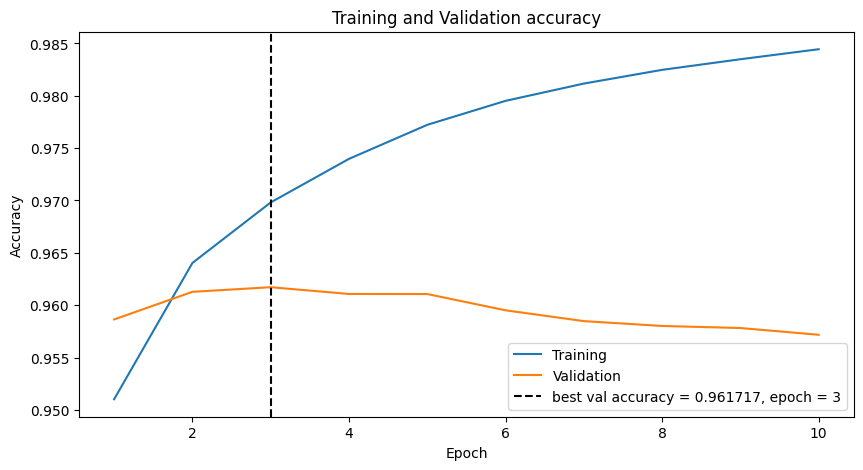

In [9]:
# Plot the training and validation history for baseline LSTM model.
savefig_base_LSTM_path_win = checkpoint_base_LSTM_path_win_aux + "_train_val_accuracy.pdf"
savefig_base_LSTM_path_linux = checkpoint_base_LSTM_path_linux_aux + "_train_val_accuracy.pdf"
if OS_system == 1:
    savefig_base_LSTM_path = savefig_base_LSTM_path_linux
else:
    savefig_base_LSTM_path = savefig_base_LSTM_path_win

base_LSTM_epoch_best_metric, base_LSTM_best_metric = plot_train_val_metric(model_base_LSTM_history, 'accuracy', 'Accuracy', savefig_base_LSTM_path)

2023-07-30 19:36:40.792829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 19:36:40.793899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 19:36:40.794604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

   84/33540 [..............................] - ETA: 40s   

2023-07-30 19:36:41.233138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 19:36:41.233955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 19:36:41.234556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10482/10482 [==============================] - 9s 896us/step
Model: Baseline LSTM
	Train Accuracy: 0.9745
	Validation Accuracy: 0.9617
	Test Accuracy: 0.9620

Performance for training set:


,name,accuracy,precision,recall/sensitivity,specificity,F1,ROC AUC,preprocess time,training time
0,Baseline LSTM,0.9745,0.9725,0.9765,0.9724,0.9745,0.9957,0.23,21.28



Performance for validation set:


,name,accuracy,precision,recall/sensitivity,specificity,F1,ROC AUC,predict time
0,Baseline LSTM,0.9617,0.9586,0.9652,0.9582,0.9619,0.9916,0.15



Performance for test set:


,name,accuracy,precision,recall/sensitivity,specificity,F1,ROC AUC,predict time
0,Baseline LSTM,0.962,0.9594,0.9648,0.9591,0.9621,0.9914,0.19


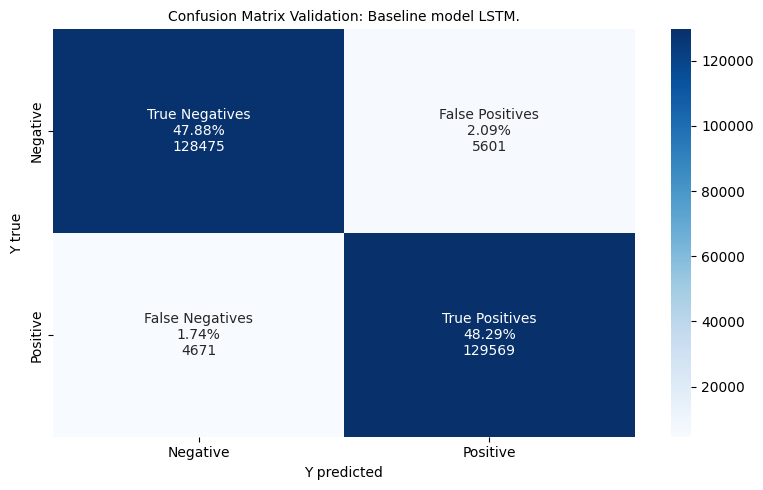

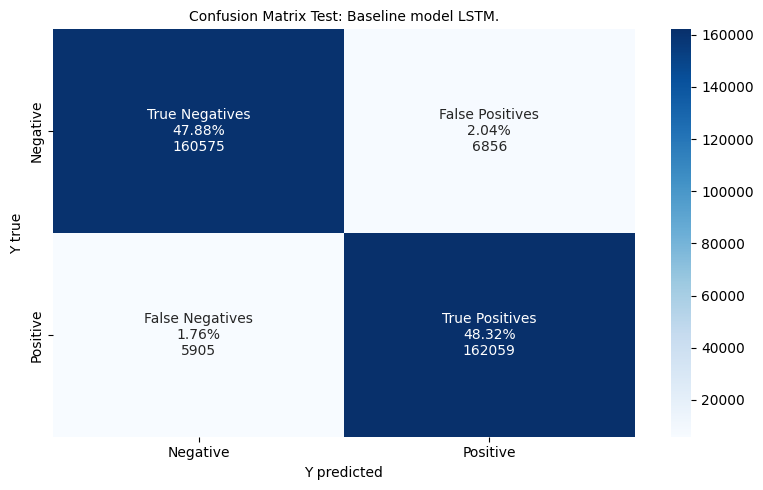

In [47]:
# Load best saved model
if base_LSTM_epoch_best_metric > 9:
    best_epoch_aux = "_00" + str(base_LSTM_epoch_best_metric)
else:
    best_epoch_aux = "_000" + str(base_LSTM_epoch_best_metric)
best_base_LSTM_path_win = checkpoint_base_LSTM_path_win_aux + best_epoch_aux + ".h5"
best_base_LSTM_path_linux = checkpoint_base_LSTM_path_linux_aux + best_epoch_aux + ".h5"
if OS_system == 1:
    best_base_LSTM_path = best_base_LSTM_path_linux
else:
    best_base_LSTM_path = best_base_LSTM_path_win
# A compiled model is needed for training but not necessary for predicting.
model_base_LSTM = tf.keras.models.load_model(best_base_LSTM_path, compile = False)

# Save metrics
if OS_system == 1:
    savedf_path = checkpoint_base_LSTM_path_linux_aux
    savefig_path = checkpoint_base_LSTM_path_linux_aux
else:
    savedf_path = checkpoint_base_LSTM_path_win_aux
    savefig_path = checkpoint_base_LSTM_path_win_aux
metrics_train, metrics_val, metrics_test, y_pred_base_LSTM = save_metrics('Baseline LSTM', model_base_LSTM
                                                                         , X_train_LSTM_encoded, y_train
                                                                         , X_val_LSTM_encoded, y_val
                                                                         , X_test_LSTM_encoded, y_test
                                                                         , base_LSTM_preprocess_time, base_LSTM_model_time
                                                                         , metrics_train, metrics_val, metrics_test
                                                                         , savedf_path)
print()
print('Performance for training set:')
display(pd.DataFrame(metrics_train))
print()
print('Performance for validation set:')
display(pd.DataFrame(metrics_val))
print()
print('Performance for test set:')
display(pd.DataFrame(metrics_test))

print()
plot_confusion_matrix(y_val,  y_pred_base_LSTM['val'], 'Confusion Matrix Validation: Baseline model LSTM.', savefig_path + "_confusion_matrix_validation.pdf")
print()
plot_confusion_matrix(y_test,  y_pred_base_LSTM['test'], 'Confusion Matrix Test: Baseline model LSTM.', savefig_path + "_confusion_matrix_test.pdf")

The baseline model already has a great performance with an accuracy of 0.96. However, after two epochs the model starts to overfitting. \
To solve this we could use regularization and dropouts layers. Another more practical method is to use transfer learning in a well know architecture. \
First, I wil try the BERT model. After, I will try DistilBERT.

<div id='BERT' />

## BERT

In [11]:
# BERT Tokenization
start = time.time()
max_len = 60 # Using a max length of 60, we get more than 95% of the reviews.
def BERT_tokenized_data(X, max_length):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
    X_processed = tokenizer(
            list(X),
            return_tensors = 'tf',
            add_special_tokens = True, # add [CLS], [SEP]
            max_length = max_length,
            padding = 'max_length',
            return_token_type_ids = False,
            return_attention_mask = True,
            truncation = True
        )
    return X_processed, tokenizer

X_train_BERT, tokenizer_bert = BERT_tokenized_data(X_train, max_length = max_len)
X_val_BERT, tokenizer_bert = BERT_tokenized_data(X_val, max_length = max_len)
X_test_BERT, tokenizer_bert = BERT_tokenized_data(X_test, max_length = max_len)

# Display keys in processed input dictionary
print(X_train_BERT.keys())

end = time.time()
BERT_tokenizer_time = (end - start)
BERT_tokenizer_time = f'{BERT_tokenizer_time/60:.2f}'
print('Run time in minutes:', BERT_tokenizer_time)

dict_keys(['input_ids', 'attention_mask'])
Run time in minutes: 5.92


In [12]:
def create_model_BERT(max_len):
    tf.keras.backend.clear_session()
    model_BERT_aux = TFBertModel.from_pretrained('bert-base-uncased')

    input_ids = Input(shape = (max_len,), dtype = tf.int32, name = "input_ids")
    input_mask = Input(shape = (max_len,), dtype = tf.int32, name = "attention_mask")

    last_hidden_state = model_BERT_aux([input_ids, input_mask])[0] # 0 = last hidden state, 1 = poller_output
    # https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379:
    # We only care about DistilBERT's output for the [CLS] token, 
    # which is located at index 0 of every encoded sequence.  
    # Splicing out the [CLS] tokens gives us 2D data. 
    cls_token = last_hidden_state[:, 0, :]
    x = Dense(32, activation = 'relu')(cls_token)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = Dense(1, activation = 'sigmoid', name = 'output')(x)
    model = keras.Model(inputs = [input_ids, input_mask], outputs = output)
    model.layers[2].trainable = False
    model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(),
                  metrics = ['accuracy'],
                 )
    return model

model_BERT = create_model_BERT(max_len)
model_BERT.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [13]:
# Save model
start = time.time()
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_BERT_path,
                                                 save_weights_only = False,
                                                 verbose = 1)
callbacks = [cp_callback]
# Training BERT
model_BERT_history = model_BERT.fit(x = {'input_ids':X_train_BERT['input_ids'], 'attention_mask':X_train_BERT['attention_mask']}
                                    , y = y_train
                                    , validation_data = ({'input_ids':X_val_BERT['input_ids'], 'attention_mask':X_val_BERT['attention_mask']}, y_val)
                                    , epochs = 10
                                    , batch_size = 32
                                    , shuffle = True
                                    , callbacks = callbacks
                                    , verbose = 1)

end = time.time()
BERT_model_time = (end - start)
BERT_model_time = f'{BERT_model_time/60:.2f}'
print('Run time in minutes:', BERT_model_time)

Epoch 1/10
33540/33540 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9180
Epoch 1: saving model to /home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/BERT/model_BERT_0001.h5
33540/33540 [==============================] - 4521s 135ms/step - loss: 0.2147 - accuracy: 0.9180 - val_loss: 0.1682 - val_accuracy: 0.9363
Epoch 2/10
33540/33540 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9238
Epoch 2: saving model to /home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/BERT/model_BERT_0002.h5
33540/33540 [==============================] - 4520s 135ms/step - loss: 0.2020 - accuracy: 0.9238 - val_loss: 0.1646 - val_accuracy: 0.9381
Epoch 3/10
33540/33540 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9252
Epoch 3: saving model to /home/max/Python/Harvard/Electives/1 CSCI S-89 

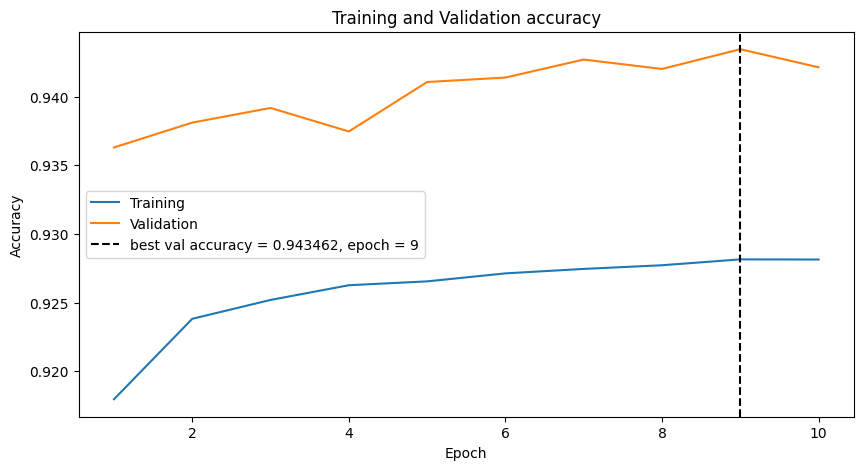

In [14]:
# Plot the training and validation history for baseline LSTM model.
savefig_BERT_path_win = checkpoint_BERT_path_win_aux + "_train_val_accuracy.pdf"
savefig_BERT_path_linux = checkpoint_BERT_path_linux_aux + "_train_val_accuracy.pdf"
if OS_system == 1:
    savefig_BERT_path = savefig_BERT_path_linux
else:
    savefig_BERT_path = savefig_BERT_path_win
    
BERT_epoch_best_metric, BERT_best_metric = plot_train_val_metric(model_BERT_history, 'accuracy', 'Accuracy', savefig_BERT_path)

10482/10482 [==============================] - 1063s 101ms/step
Model: BERT
	Train Accuracy: 0.9439
	Validation Accuracy: 0.9435
	Test Accuracy: 0.9436

Performance for training set:


,name,accuracy,precision,recall/sensitivity,specificity,F1,ROC AUC,preprocess time,training time
0,Baseline LSTM,0.9745,0.9725,0.9765,0.9724,0.9745,0.9957,0.23,21.28
1,BERT,0.9439,0.9515,0.9354,0.9524,0.9434,0.9853,5.92,752.28



Performance for validation set:


,name,accuracy,precision,recall/sensitivity,specificity,F1,ROC AUC,predict time
0,Baseline LSTM,0.9617,0.9586,0.9652,0.9582,0.9619,0.9916,0.15
1,BERT,0.9435,0.9512,0.9350,0.9519,0.9430,0.9852,14.22



Performance for test set:


,name,accuracy,precision,recall/sensitivity,specificity,F1,ROC AUC,predict time
0,Baseline LSTM,0.9620,0.9594,0.9648,0.9591,0.9621,0.9914,0.19
1,BERT,0.9436,0.9514,0.9351,0.9521,0.9432,0.9851,17.76


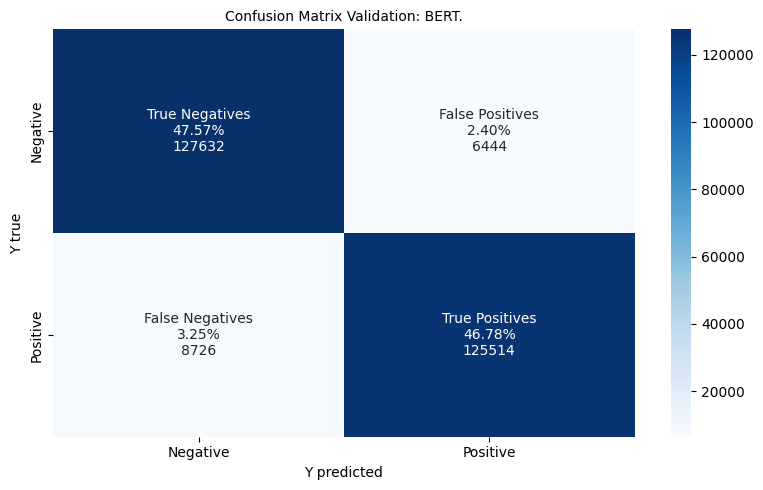

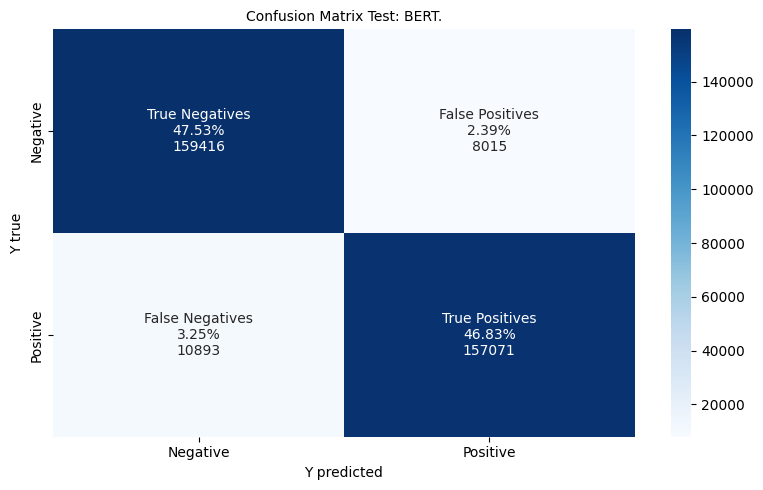

In [48]:
# Load best saved model
best_epoch_aux = BERT_epoch_best_metric
if BERT_epoch_best_metric > 9:
    best_epoch_aux = "_00" + str(BERT_epoch_best_metric)
else:
    best_epoch_aux = "_000" + str(BERT_epoch_best_metric)
best_BERT_path_win = checkpoint_BERT_path_win_aux + best_epoch_aux + ".h5"
best_BERT_path_linux = checkpoint_BERT_path_linux_aux + best_epoch_aux + ".h5"
if OS_system == 1:
    best_BERT_path = best_BERT_path_linux
else:
    best_BERT_path = best_BERT_path_win
# A compiled model is needed for training but not necessary for predicting.
model_best_epoch_BERT = tf.keras.models.load_model(best_BERT_path, custom_objects={"TFBertModel": transformers.TFBertModel}, compile = False) 
# Save metrics
if OS_system == 1:
    savedf_path = checkpoint_BERT_path_linux_aux
    savefig_path = checkpoint_BERT_path_linux_aux
else:
    savedf_path = checkpoint_BERT_path_win_aux
    savefig_path = checkpoint_BERT_path_win_aux
metrics_train, metrics_val, metrics_test, y_pred_BERT = save_metrics('BERT', model_best_epoch_BERT
                                                                         , X_train_BERT, y_train
                                                                         , X_val_BERT, y_val
                                                                         , X_test_BERT, y_test
                                                                         , BERT_tokenizer_time,BERT_model_time
                                                                         , metrics_train, metrics_val, metrics_test
                                                                         , savedf_path)
print()
print('Performance for training set:')
display(pd.DataFrame(metrics_train))
print()
print('Performance for validation set:')
display(pd.DataFrame(metrics_val))
print()
print('Performance for test set:')
display(pd.DataFrame(metrics_test))

print()
plot_confusion_matrix(y_val,  y_pred_BERT['val'], 'Confusion Matrix Validation: BERT.', savefig_path + "_confusion_matrix_validation.pdf")
print()
plot_confusion_matrix(y_test,  y_pred_BERT['test'], 'Confusion Matrix Test: BERT.', savefig_path + "_confusion_matrix_test.pdf")

<div id='DistilBERT' />

## DistilBERT

In [16]:
# DistilBERT Tokenization
start = time.time()
max_len = 60 # Using a max length of 60, we get more than 95% of the reviews.
def DistilBERT_tokenized_data(X, max_length):  
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case = True)
    X_processed = tokenizer(
            list(X),
            return_tensors = 'tf',
            add_special_tokens = True, # add [CLS], [SEP]
            max_length = max_length,
            padding = 'max_length',
            return_token_type_ids = False,
            return_attention_mask = True,
            truncation = True
        )
    return X_processed, tokenizer

X_train_DistilBERT, tokenizer_Distilbert = DistilBERT_tokenized_data(X_train, max_length = max_len)
X_val_DistilBERT, tokenizer_Distilbert = DistilBERT_tokenized_data(X_val, max_length = max_len)
X_test_DistilBERT, tokenizer_Distilbert = DistilBERT_tokenized_data(X_test, max_length = max_len)

# Display keys in processed input dictionary
print(X_train_DistilBERT.keys())

end = time.time()
DistilBERT_tokenizer_time = (end - start)
DistilBERT_tokenizer_time = f'{DistilBERT_tokenizer_time/60:.2f}'
print('Run time in minutes:', DistilBERT_tokenizer_time)

dict_keys(['input_ids', 'attention_mask'])
Run time in minutes: 5.85


In [17]:
def create_model_DistilBERT(max_len):
    tf.keras.backend.clear_session()
    model_DistilBERT_aux = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    input_ids = Input(shape = (max_len,), dtype = tf.int32, name = "input_ids")
    input_mask = Input(shape = (max_len,), dtype = tf.int32, name = "attention_mask")

    last_hidden_state = model_DistilBERT_aux([input_ids, input_mask])[0]
    # We only care about DistilBERT's output for the [CLS] token, 
    # which is located at index 0 of every encoded sequence.  
    # Splicing out the [CLS] tokens gives us 2D data. (https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)
    cls_token = last_hidden_state[:, 0, :]
    
    x = Dense(32, activation = 'relu')(cls_token)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = Dense(1, activation = 'sigmoid', name = 'output')(x)
    model = keras.Model(inputs = [input_ids, input_mask], outputs = output)
    model.layers[2].trainable = False
    model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(),
                  metrics = ['accuracy'],
                 )
    return model

model_DistilBERT = create_model_DistilBERT(max_len)
model_DistilBERT.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 60, 768),                                                    
                                 hidden_states=None                                           

In [18]:
# Save model
start = time.time()
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_DistilBERT_path,
                                                 save_weights_only = False,
                                                 verbose = 1)
callbacks = [cp_callback]
# Training DistilBERT
model_DistilBERT_history = model_DistilBERT.fit(x = {'input_ids':X_train_DistilBERT['input_ids'], 'attention_mask':X_train_DistilBERT['attention_mask']}
                                    , y = y_train
                                    , validation_data = ({'input_ids':X_val_DistilBERT['input_ids'], 'attention_mask':X_val_DistilBERT['attention_mask']}, y_val)
                                    , epochs = 10
                                    , batch_size = 32
                                    , shuffle = True
                                    , callbacks = callbacks
                                    , verbose = 1)

end = time.time()
DistilBERT_model_time = (end - start)
DistilBERT_model_time = f'{DistilBERT_model_time/60:.2f}'
print('Run time in minutes:', DistilBERT_model_time)

Epoch 1/10
33539/33540 [============================>.] - ETA: 0s - loss: 0.2003 - accuracy: 0.9247
Epoch 1: saving model to /home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/DistilBERT/model_DistilBERTBERT_0001.h5
33540/33540 [==============================] - 2256s 67ms/step - loss: 0.2003 - accuracy: 0.9247 - val_loss: 0.1659 - val_accuracy: 0.9379
Epoch 2/10
33539/33540 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9298
Epoch 2: saving model to /home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/DistilBERT/model_DistilBERTBERT_0002.h5
33540/33540 [==============================] - 2259s 67ms/step - loss: 0.1886 - accuracy: 0.9298 - val_loss: 0.1625 - val_accuracy: 0.9393
Epoch 3/10
33539/33540 [============================>.] - ETA: 0s - loss: 0.1850 - accuracy: 0.9313
Epoch 3: saving model to /home/max/Python/

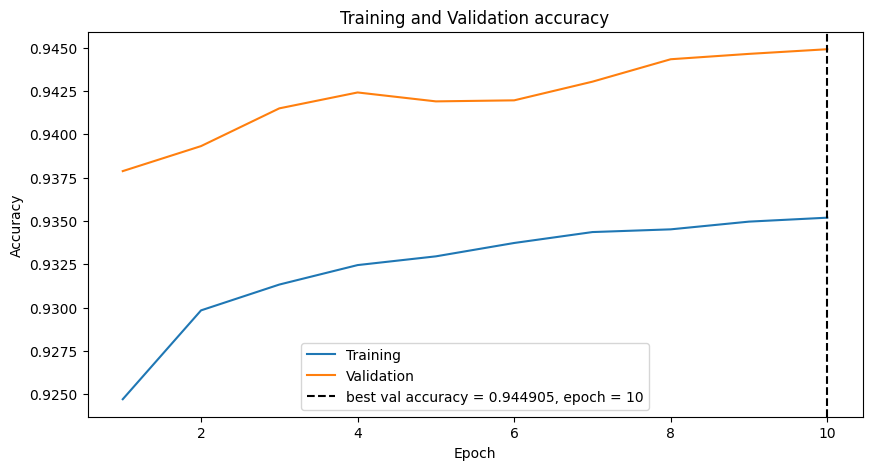

In [19]:
# Plot the training and validation history for baseline LSTM model.
savefig_DistilBERT_path_win = checkpoint_DistilBERT_path_win_aux + "_train_val_accuracy.pdf"
savefig_DistilBERT_path_linux = checkpoint_DistilBERT_path_linux_aux + "_train_val_accuracy.pdf"
if OS_system == 1:
    savefig_DistilBERT_path = savefig_DistilBERT_path_linux
else:
    savefig_DistilBERT_path = savefig_DistilBERT_path_win
    
DistilBERT_epoch_best_metric, DistilBERT_best_metric = plot_train_val_metric(model_DistilBERT_history, 'accuracy', 'Accuracy', savefig_DistilBERT_path)

10482/10482 [==============================] - 530s 51ms/step
Model: DistilBERT
	Train Accuracy: 0.9451
	Validation Accuracy: 0.9449
	Test Accuracy: 0.9446

Performance for training set:


,name,accuracy,precision,recall/sensitivity,specificity,F1,ROC AUC,preprocess time,training time
0,Baseline LSTM,0.9745,0.9725,0.9765,0.9724,0.9745,0.9957,0.23,21.28
1,BERT,0.9439,0.9515,0.9354,0.9524,0.9434,0.9853,5.92,752.28
2,DistilBERT,0.9451,0.9494,0.9404,0.9499,0.9448,0.9857,5.85,378.02



Performance for validation set:


,name,accuracy,precision,recall/sensitivity,specificity,F1,ROC AUC,predict time
0,Baseline LSTM,0.9617,0.9586,0.9652,0.9582,0.9619,0.9916,0.15
1,BERT,0.9435,0.9512,0.9350,0.9519,0.9430,0.9852,14.22
2,DistilBERT,0.9449,0.9491,0.9403,0.9495,0.9447,0.9856,7.11



Performance for test set:


,name,accuracy,precision,recall/sensitivity,specificity,F1,ROC AUC,predict time
0,Baseline LSTM,0.9620,0.9594,0.9648,0.9591,0.9621,0.9914,0.19
1,BERT,0.9436,0.9514,0.9351,0.9521,0.9432,0.9851,17.76
2,DistilBERT,0.9446,0.9493,0.9396,0.9497,0.9444,0.9855,-0.00


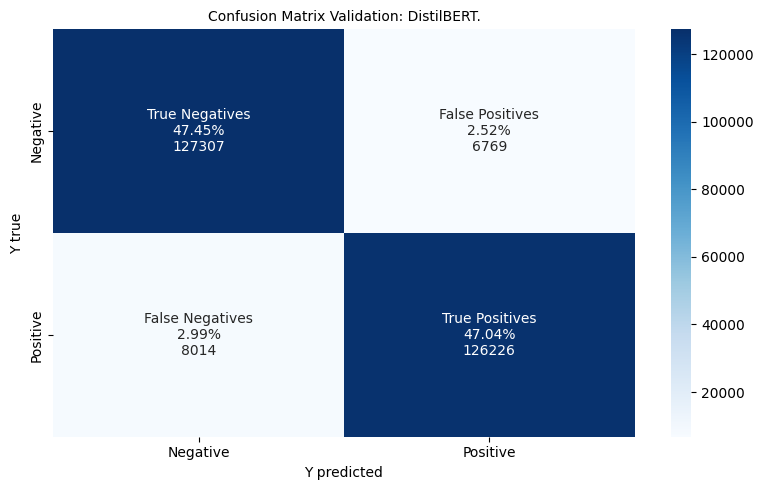

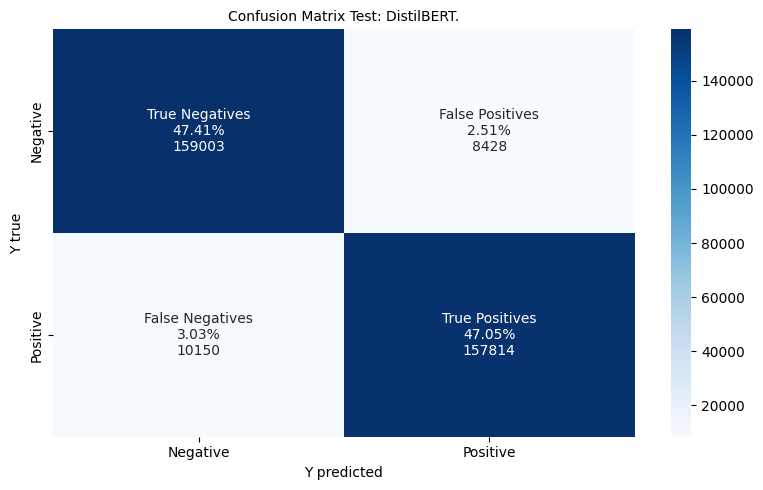

In [49]:
# Load best saved model
best_epoch_aux = DistilBERT_epoch_best_metric
if DistilBERT_epoch_best_metric > 9:
    best_epoch_aux = "_00" + str(DistilBERT_epoch_best_metric)
else:
    best_epoch_aux = "_000" + str(DistilBERT_epoch_best_metric)
best_DistilBERT_path_win = checkpoint_DistilBERT_path_win_aux + best_epoch_aux + ".h5"
best_DistilBERT_path_linux = checkpoint_DistilBERT_path_linux_aux + best_epoch_aux + ".h5"
if OS_system == 1:
    best_DistilBERT_path = best_DistilBERT_path_linux
else:
    best_DistilBERT_path = best_DistilBERT_path_win
# A compiled model is needed for training but not necessary for predicting.
model_best_epoch_DistilBERT = tf.keras.models.load_model(best_DistilBERT_path, custom_objects={"TFDistilBertModel": transformers.TFDistilBertModel}, compile = False) 

# Save metrics
if OS_system == 1:
    savedf_path = checkpoint_DistilBERT_path_linux_aux
    savefig_path = checkpoint_DistilBERT_path_linux_aux
else:
    savedf_path = checkpoint_DistilBERT_path_win_aux
    savefig_path = checkpoint_DistilBERT_path_win_aux
metrics_train, metrics_val, metrics_test, y_pred_DistilBERT = save_metrics('DistilBERT', model_best_epoch_DistilBERT
                                                                         , X_train_DistilBERT, y_train
                                                                         , X_val_DistilBERT, y_val
                                                                         , X_test_DistilBERT, y_test
                                                                         , DistilBERT_tokenizer_time, DistilBERT_model_time
                                                                         , metrics_train, metrics_val, metrics_test
                                                                         , savedf_path)
print()
print('Performance for training set:')
display(pd.DataFrame(metrics_train))
print()
print('Performance for validation set:')
display(pd.DataFrame(metrics_val))
print()
print('Performance for test set:')
display(pd.DataFrame(metrics_test))

print()
plot_confusion_matrix(y_val,  y_pred_DistilBERT['val'], 'Confusion Matrix Validation: DistilBERT.', savefig_path + "_confusion_matrix_validation.pdf")
print()
plot_confusion_matrix(y_test,  y_pred_DistilBERT['test'], 'Confusion Matrix Test: DistilBERT.', savefig_path + "_confusion_matrix_test.pdf")